# Diffusion Model Based on Impressionist Paintings

In [2]:
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "samples"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
config.dataset_name = "data"

In [18]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
dataset = torchvision.datasets.ImageFolder(config.dataset_name, preprocess)
dataset

Dataset ImageFolder
    Number of datapoints: 2287
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

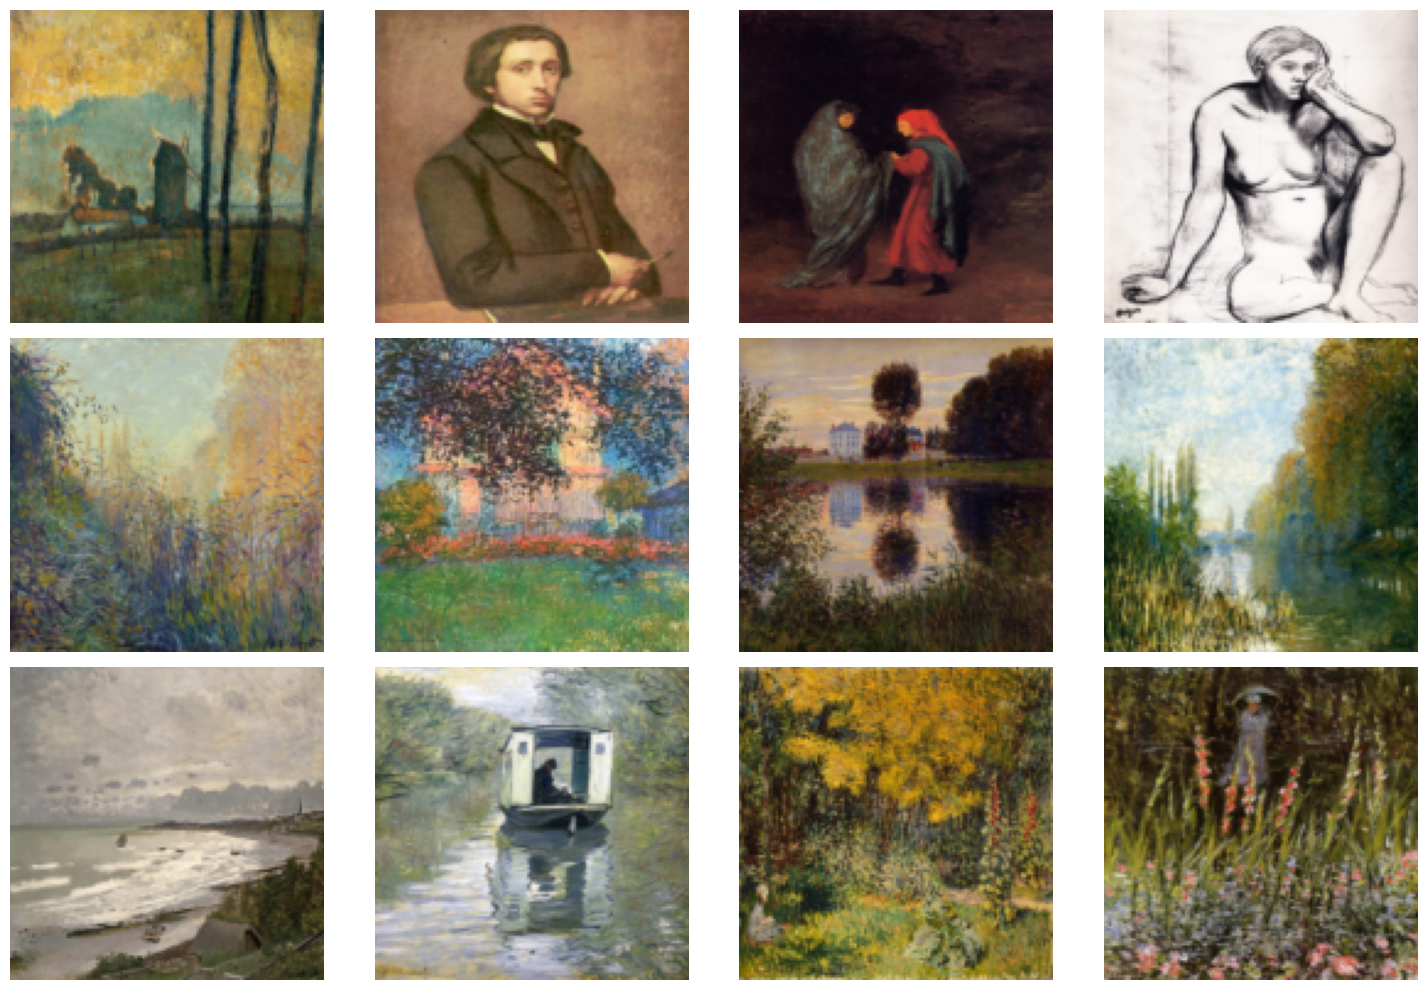

In [19]:
# Show the first 12 images of the dataset
fig, ax = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns
for i in range(12):
    row, col = divmod(i, 4)  # Compute row and column indices
    ax[row, col].imshow(((dataset[i][0].permute(1, 2, 0) + 1) / 2))
    ax[row, col].axis("off")
plt.tight_layout()
plt.show()


In [20]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [21]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [22]:
sample_image = dataset[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


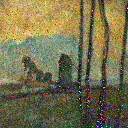

In [23]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [24]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [25]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [26]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import time
import csv

log_file = os.path.join(config.output_dir, "training_logs.csv")

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")
    
# Create a log file to save metrics
    if accelerator.is_main_process:
        log_filec = os.path.join(config.output_dir, "training_logs.csv")
        with open(log_file, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["global_step", "epoch", "step", "loss", "learning_rate"])

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0].to(accelerator.device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            if accelerator.is_main_process:
                with open(log_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([global_step, epoch, step, logs["loss"], logs["lr"]])

            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [28]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
# save the model for later use
model.save_pretrained(config.output_dir)

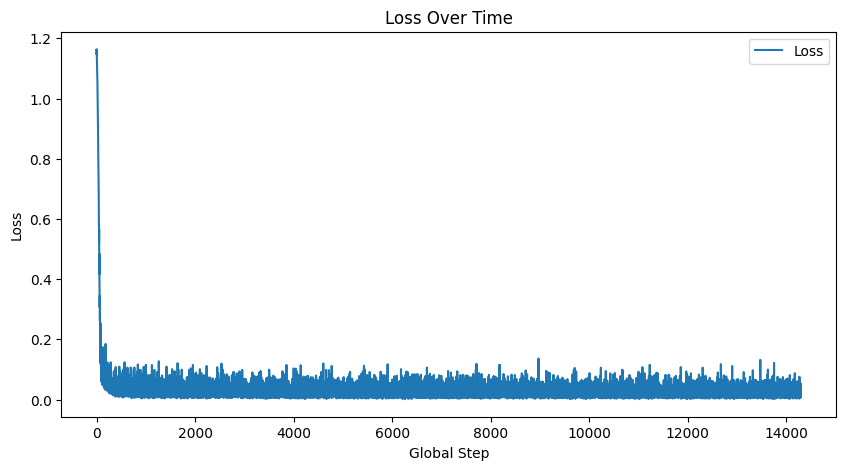

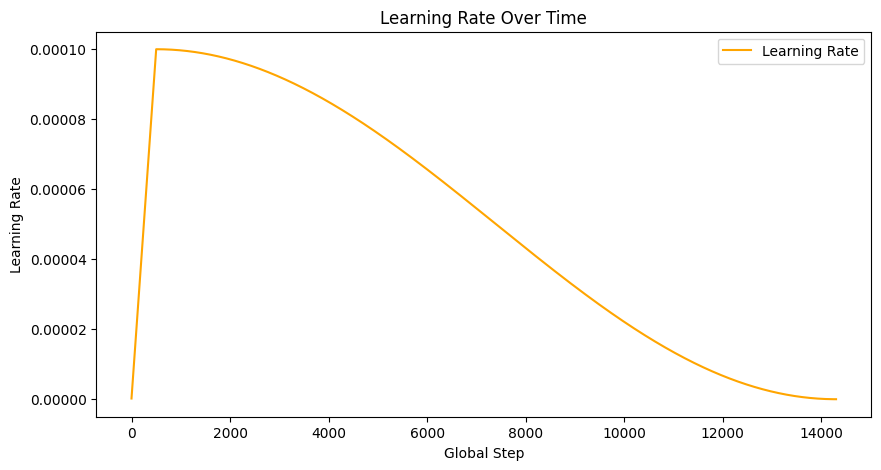

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log file
log_file = os.path.join(config.output_dir, "training_logs.csv")
logs = pd.read_csv(log_file)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(logs["global_step"], logs["loss"], label="Loss")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()
plt.show()

# Plot Learning Rate
plt.figure(figsize=(10, 5))
plt.plot(logs["global_step"], logs["learning_rate"], label="Learning Rate", color="orange")
plt.xlabel("Global Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Time")
plt.legend()
plt.show()


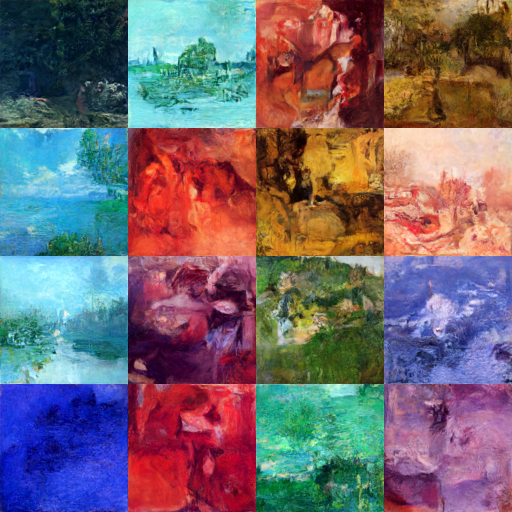

In [ ]:
import glob
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [72]:

def generate(pipeline, num_images=1, config=config):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=num_images,
        # random seed for reproducibility
        generator=torch.Generator(device='cpu').manual_seed(43),  # seed 42 works well for this example
    ).images
    return images

# Load the trained pipeline
pipeline = DDPMPipeline.from_pretrained(config.output_dir)

# Ensure pipeline is set to evaluation mode
pipeline.unet.eval()

# Define the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pipeline.to(device)

# Generate images (now passing pipeline, not config)
images = generate(pipeline, num_images=12)  # Example: generating 1 image

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

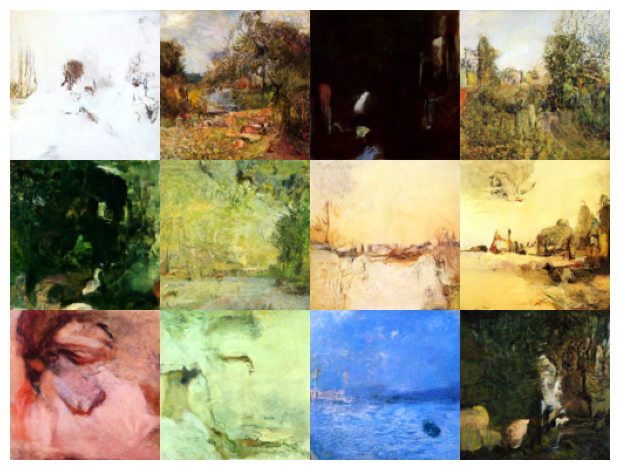

In [73]:
# Calculate exact grid dimensions
# only 8 first
num_images = len(images)
cols = min(num_images, 4)  # Max 4 columns
rows = (num_images + cols - 1) // cols  # Compute rows to fit all images
# Make a grid out of the images 4 columns and the rest rows
image_grid = make_image_grid(images, rows=rows, cols=cols)
plt.imshow(image_grid)
plt.axis("off")
plt.tight_layout()
plt.show()

[<PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B8A3B520>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B18936A0>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B18936D0>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B1893FD0>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B18930D0>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B1893550>, <PIL.Image.Image image mode=RGB size=128x128 at 0x7F93B1893E80>]


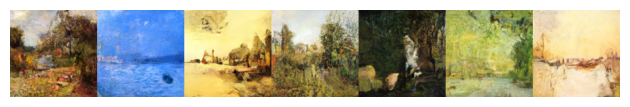

In [ ]:
# select only [1,3,5,6,7,10,11] images
first_images = [images[i] for i in [1, 10, 7, 3, 11, 5, 6]]
print(first_images)
num_images = len(first_images)

# Set columns to 4, or use fewer columns if you don't have enough images to fill
cols = min(num_images, )

# Compute rows based on the number of images and columns
rows = (num_images + cols - 1) // cols

# If the grid doesn't exactly match the number of images, pad with empty spaces (None)
while len(first_images) < rows * cols:
    first_images.append(None)  # Padding the list with None

# Make the image grid
image_grid_2 = make_image_grid(first_images, rows=rows, cols=cols)
plt.imshow(image_grid_2)
plt.axis("off")
plt.tight_layout()
plt.show()


In [26]:
import torch
from PIL import Image
import numpy as np
from typing import Optional, Tuple, Union
from diffusers import DDPMPipeline, ImagePipelineOutput
from diffusers.utils import deprecate
import torch
from diffusers.configuration_utils import FrozenDict
torch.cuda.empty_cache()

# Assuming the DDPMPipeline and ImagePipelineOutput are already defined

class ModifiedDDPMPipeline(DDPMPipeline):
    def __init__(self, unet, scheduler):
        super().__init__(unet, scheduler)

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[torch.Generator] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        Args:
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            num_inference_steps (`int`, *optional*, defaults to 1000):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipeline_utils.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipeline_utils.ImagePipelineOutput`] or `tuple`: [`~pipelines.utils.ImagePipelineOutput`] if
            `return_dict` is True, otherwise a `tuple. When returning a tuple, the first element is a list with the
            generated images.
        """
        message = (
            "Please make sure to instantiate your scheduler with `prediction_type` instead. E.g. `scheduler ="
            " DDPMScheduler.from_pretrained(<model_id>, prediction_type='epsilon')`."
        )
        
        if generator is not None and generator.device.type != self.device.type and self.device.type != "mps":
            message = (
                f"The `generator` device is `{generator.device}` and does not match the pipeline "
                f"device `{self.device}`, so the `generator` will be ignored. "
                f'Please use `torch.Generator(device="{self.device}")` instead.'
            )
            deprecate(
                "generator.device == 'cpu'",
                "0.11.0",
                message,
            )
            generator = None

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.sample_size, int):
            image_shape = (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size)
        else:
            image_shape = (batch_size, self.unet.in_channels, *self.unet.sample_size)

        if self.device.type == "mps":
            # randn does not work reproducibly on mps
            image = torch.randn(image_shape, generator=generator)
            image = image.to(self.device)
        else:
            image = torch.randn(image_shape, generator=generator, device=self.device)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)
        noisy_images = []
        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t).sample

            # 2. compute previous image: x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample
            if t%100 == 0:
                # Store the noisy image (before denoising step)
                noisy_image = (image / 2 + 0.5).clamp(0, 1)
                noisy_image = noisy_image.cpu().permute(0, 2, 3, 1).numpy()
                if output_type == "pil":
                    noisy_image = self.numpy_to_pil(noisy_image)
                noisy_images.append(noisy_image)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)
        
        return (image, noisy_images)  # Reverse to get noisiest first
    


# Load the trained pipeline
pipeline = DDPMPipeline.from_pretrained(config.output_dir)
# Ensure pipeline is set to evaluation mode
pipeline.unet.eval()
modified_pipeline = ModifiedDDPMPipeline(pipeline.unet, pipeline.scheduler)

# Generate images and retrieve all noisy images
output = modified_pipeline(batch_size=1, 
                           generator=torch.Generator(device='cpu').manual_seed(config.seed),
                        )  # seed 42 works well for this example




Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_464806/988353726.py:68: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  image_shape = (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size)


  0%|          | 0/1000 [00:00<?, ?it/s]

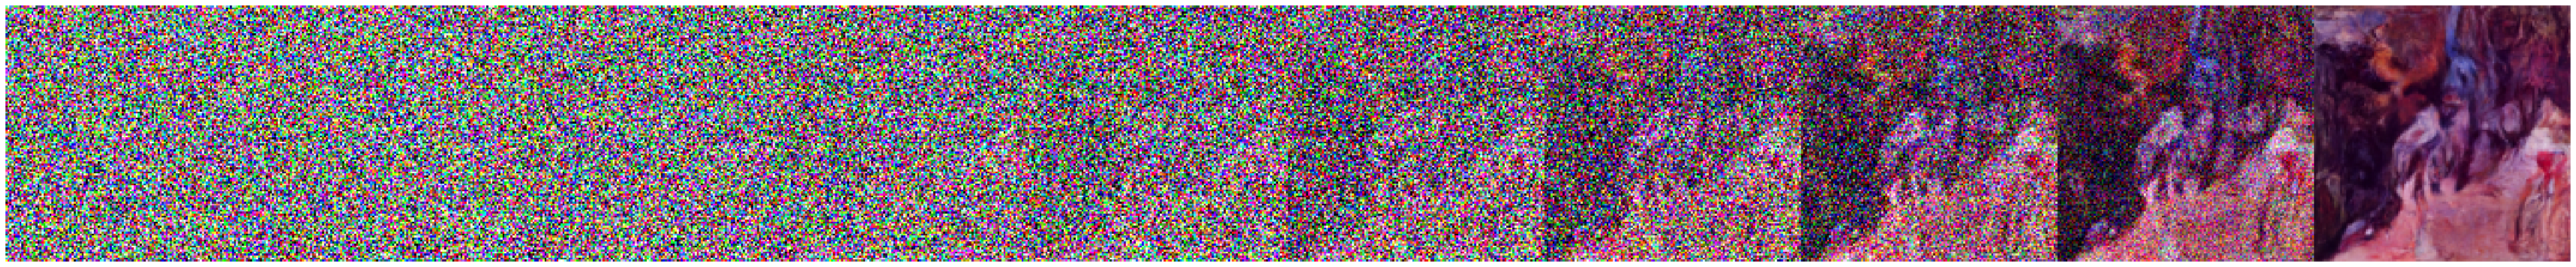

In [27]:
# print evolution of noisy images (from noisiest to cleanest)
# Retrieve and print all noisy images (from noisiest to cleanest)
noisy_images = [output[1][i][0] for i in range(len(output[1]))]
num_images = len(noisy_images)
cols = num_images
rows = 1
from diffusers.utils import make_image_grid
# Make a grid out of the images 4 columns and the rest rows
plt.figure(figsize=(5*num_images, 5))
image_grid = make_image_grid(noisy_images, rows=rows, cols=cols)
plt.imshow(image_grid)
plt.axis("off")
plt.tight_layout()
plt.show()



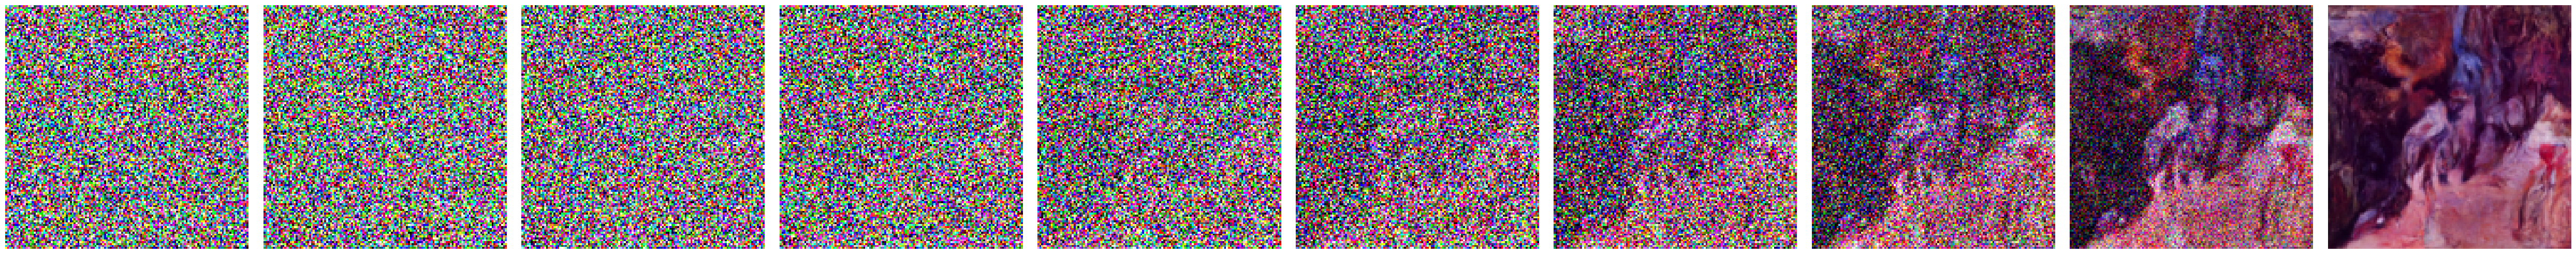

In [28]:
# this times without making grid, just show the images
plt.figure(figsize=(5*num_images, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(noisy_images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()